In [1]:
#Importiamo le librerie utili
import time
import numpy as np
import scipy.stats
from scipy.integrate import odeint
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import logging
logging.basicConfig(level=logging.INFO)
%matplotlib inline
%precision 2

import elfi

#Prendiamo un seed arbitrario per riproducibilità dei risultati
seed = 19030815 
np.random.seed(seed)

#Input, tempo e condizioni iniziali
g=9.81
t0=0
t1=20 #20s
t=np.linspace(t0,t1,240)
th_0=[0,3] #Angolo e velocità angolare al tempo 0

In [2]:
#Definiamo il modello
def fun(th,t,g,l):
    th_1=th[0]
    th_2=th[1]
    dth_1=th_2
    dth_2=-g/l*np.sin(th_1)
    dth=[dth_1,dth_2]
    return dth

def pd(g,l,th_0,t,fun,n_obs=10,batch_size=1,random_state=None):
    th=odeint(fun,th_0,t,args=(g,l))
    n0=np.random.normal(loc=0,scale=0.05,size=len(th))
    n1=np.random.normal(loc=0,scale=0.1,size=len(th))
    th_noise=[th[:,0]+n0,th[:,1]+n1] #Aggiunta rumore gaussiano
    return th_noise[1] #Ritorniamo solo la velocità angolare (possibile causa outlier)

In [3]:
#Valori ottenuti con l=3
obs=pd(g,3,th_0,t,fun)
obs

array([ 3.13,  2.99,  2.83,  2.65,  2.39,  2.28,  2.05,  1.71,  1.43,
        1.25,  0.87,  0.75,  0.25,  0.13, -0.1 , -0.26, -0.72, -0.86,
       -1.26, -1.41, -1.86, -2.19, -2.15, -2.47, -2.51, -2.89, -2.75,
       -2.98, -3.13, -2.84, -2.64, -2.53, -2.33, -2.22, -1.73, -1.48,
       -1.23, -0.99, -0.6 , -0.57, -0.04,  0.1 ,  0.3 ,  0.77,  0.75,
        1.09,  1.23,  1.65,  1.91,  2.11,  2.3 ,  2.58,  2.74,  2.89,
        3.  ,  2.95,  3.11,  2.78,  2.67,  2.62,  1.91,  1.84,  1.71,
        1.42,  1.03,  0.76,  0.4 ,  0.23,  0.12, -0.25, -0.48, -1.  ,
       -0.97, -1.2 , -1.66, -2.  , -2.08, -2.5 , -2.63, -2.83, -3.04,
       -2.91, -3.14, -3.05, -2.7 , -2.63, -2.3 , -1.95, -1.95, -1.65,
       -1.44, -1.22, -0.7 , -0.72, -0.33, -0.06,  0.25,  0.47,  0.76,
        1.08,  1.13,  1.48,  1.63,  2.09,  2.44,  2.62,  2.95,  2.87,
        3.  ,  3.23,  3.19,  2.82,  2.8 ,  2.64,  2.34,  2.02,  1.71,
        1.35,  1.01,  0.76,  0.68,  0.47,  0.08, -0.13, -0.47, -0.61,
       -0.85, -1.18,

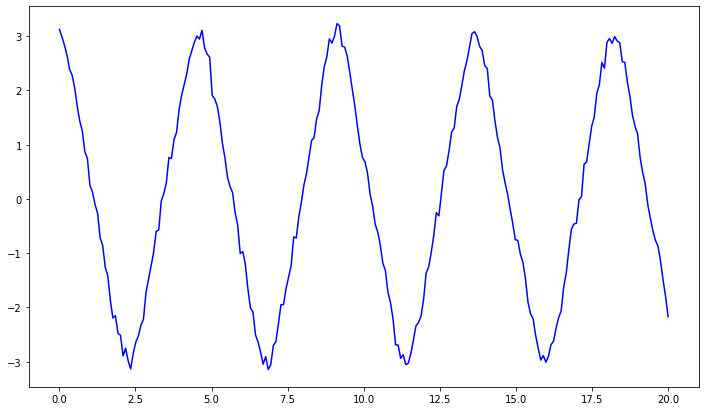

In [4]:
#Velocità angolare in funzione del tempo, con rumore gaussiano
plt.figure(figsize=(12,7))
plt.plot(t,obs,'b-')
plt.show()

In [5]:
#Settiamo una priori uniforme (abbastanza ampia e quindi poco informativa) per l
l=elfi.Prior(scipy.stats.uniform,0,7)

In [6]:
#Definiamo il nodo simulatore di elfi, basato su prior e modello
Y=elfi.Simulator(pd,g,l,th_0,t,fun,observed=obs)

In [7]:
def autocov(x, lag = 1):
    C = np.mean(x[lag:] * x[:-lag])
    return C

In [8]:
#Definiamo i nodi summary di elfi
S1 = elfi.Summary(autocov, Y)
S2 = elfi.Summary(autocov, Y, 2)

In [9]:
#Concludiamo il modello con la definizione euclidea di distanza
d = elfi.Distance('euclidean', S1, S2)

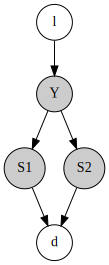

In [10]:
#Controlliamo tramite l'utilizzo di Graphviz la corretta struttura dei nodi scelti
elfi.draw(d)

In [11]:
#Sequential Monte Carlo
smc = elfi.SMC(d, batch_size=1, seed=seed)

In [12]:
schedule = [0.5, 0.05, 0.005]
%time result_smc = smc.sample(1000, schedule)

INFO:elfi.methods.inference.samplers:---------------- Starting round 0 ----------------
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


ABC-SMC Round 1 / 3


INFO:elfi.methods.inference.samplers:---------------- Starting round 1 ----------------


Progress [==================================================] 100.0% Complete
ABC-SMC Round 2 / 3


 C:\Users\giuli\anaconda3\envs\elfi\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning:Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.


INFO:elfi.methods.inference.samplers:---------------- Starting round 2 ----------------


Progress [==================================================] 100.0% Complete
ABC-SMC Round 3 / 3
Progress [==================================================] 100.0% Complete
Wall time: 50min 37s


In [13]:
result_smc.summary(all=True)

Method: SMC
Number of samples: 1000
Number of simulations: 283105
Threshold: 0.00499
Sample means: l: 3.08

Population 0:
Method: Rejection within SMC-ABC
Number of samples: 1000
Number of simulations: 2297
Threshold: 0.499
Sample means: l: 2.64

Population 1:
Method: Rejection within SMC-ABC
Number of samples: 1000
Number of simulations: 29095
Threshold: 0.05
Sample means: l: 3.25

Population 2:
Method: Rejection within SMC-ABC
Number of samples: 1000
Number of simulations: 251713
Threshold: 0.00499
Sample means: l: 3.08


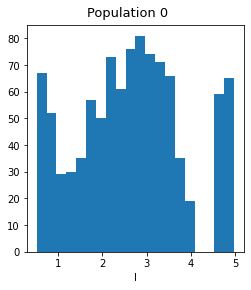

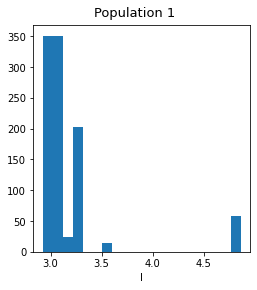

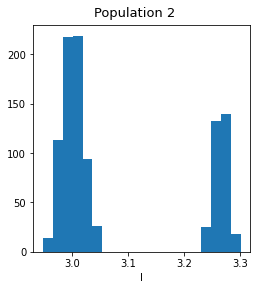

In [14]:
result_smc.plot_marginals(all=True)

In [15]:
#I risultati sono in linea con quello che ci aspettiamo, con un miglioramento più netto
#associato ad una threshold più stretta.
#La presenza di outlier, anche nelle popolazioni più "precise" può essere causato ad esempio
#dalla scelta (obbligata dalle interazioni sfortunate tra il comando odeint e il comando smc.sample) 
#di utilizzare solamente la velocità angolare come valore osservato.